In [2]:
import os 

base_dir = 'C:/Users/vian8/Desktop/Tugas2/SNAPGRADE/model/dataset/Combined/'
subdirs = ['X', 'Not_X']

x_dir = os.path.join(base_dir, subdirs[0])
not_x_dir = os.path.join(base_dir, subdirs[1])

print(os.listdir(base_dir))
print(len(os.listdir(x_dir)))
print(len(os.listdir(not_x_dir)))

['Not_X', 'X']
5112
4892


In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

batch_size = 64

train_datagen = ImageDataGenerator(
    rescale = 1.0/255,
    horizontal_flip = True, 
    vertical_flip = True, 
    rotation_range = 30, 
    height_shift_range = 0.2, 
    width_shift_range = 0.2, 
    shear_range = 0.2, 
    fill_mode = 'nearest',
    validation_split = 0.2
)

val_datagen = ImageDataGenerator(
    rescale = 1.0/255, 
    validation_split = 0.2
)

train_gen = train_datagen.flow_from_directory(
    base_dir,
    target_size = (32, 32), 
    batch_size = batch_size, 
    class_mode = 'categorical', 
    shuffle = True, 
    subset = 'training'
)

val_gen = val_datagen.flow_from_directory(
    base_dir, 
    target_size = (32, 32), 
    batch_size = batch_size, 
    class_mode = 'categorical', 
    shuffle = True, 
    subset = 'validation'
)

Found 8004 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [23]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

base_model = MobileNetV2(
    weights = 'imagenet', 
    include_top = False,
    pooling = 'max',
    input_tensor = Input(shape = (32, 32, 3))    
    )

model_without_pooling = Model(
    inputs=base_model.input, 
    outputs=base_model.get_layer('out_relu').output
    )

# for layer in base_model.layers: 
#     layer.trainable = False
    
base_model.summary() 

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 16, 16, 32)           864       ['input_3[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 16, 16, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 16, 16, 32)           0         ['bn_Conv1[

In [27]:
import tensorflow as tf 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout, Conv2D, GlobalAveragePooling2D, BatchNormalization

model = Sequential([
    model_without_pooling, 
    Conv2D(64, (3,3), activation = 'relu', padding = 'same'),
    GlobalAveragePooling2D(),
    Dense(512, activation = 'relu'),
    BatchNormalization(),
    # MaxPooling2D(2,2),
    Dense(128, activation = 'relu'), 
    Dropout(0.2), 
    Dense(64, activation = 'relu'),
    Dense(2, activation = 'softmax')    
])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, 1, 1, 1280)        2257984   
                                                                 
 conv2d_5 (Conv2D)           (None, 1, 1, 64)          737344    
                                                                 
 global_average_pooling2d_2  (None, 64)                0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_23 (Dense)            (None, 512)               33280     
                                                                 
 batch_normalization_2 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dense_24 (Dense)            (None, 128)              

In [29]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

checkpoint_path = 'C:/Users/vian8/Desktop/Tugas2/SNAPGRADE/model/model_checkpoint.h5'
checkpoint = ModelCheckpoint(
    checkpoint_path, 
    monitor = 'val_accuracy', 
    save_best_only = True, 
    mode = 'max', 
    verbose = 1
)

lr_reduce = ReduceLROnPlateau(
    monitor = 'val_accuracy', 
    patience = 3,
    factor = 0.1,
    min_lr = 0.000001,
    verbose = 1
)

model.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.optimizers.Adam(learning_rate = 0.001),
    metrics = ['accuracy']
)

train_steps = round(8004/batch_size)
val_steps = round(2000/batch_size)

print(train_steps)
print(val_steps)

125
31


In [30]:
hist = model.fit(
    train_gen, 
    steps_per_epoch = train_steps, 
    validation_data = val_gen,
    validation_steps = val_steps,
    epochs = 30, 
    verbose = 1, 
    callbacks = [checkpoint, lr_reduce]
)

Epoch 1/30
125/125 [==============================] - ETA: 0s - loss: 0.2063 - accuracy: 0.9230
Epoch 1: val_accuracy improved from -inf to 0.52923, saving model to C:/Users/vian8/Desktop/Tugas2/SNAPGRADE/model\model_checkpoint.h5
125/125 [==============================] - 47s 218ms/step - loss: 0.2063 - accuracy: 0.9230 - val_loss: 3.5664 - val_accuracy: 0.5292 - lr: 0.0010
Epoch 2/30
125/125 [==============================] - ETA: 0s - loss: 0.1474 - accuracy: 0.9462
Epoch 2: val_accuracy improved from 0.52923 to 0.91331, saving model to C:/Users/vian8/Desktop/Tugas2/SNAPGRADE/model\model_checkpoint.h5
125/125 [==============================] - 27s 213ms/step - loss: 0.1474 - accuracy: 0.9462 - val_loss: 1.0490 - val_accuracy: 0.9133 - lr: 0.0010
Epoch 3/30
125/125 [==============================] - ETA: 0s - loss: 0.1054 - accuracy: 0.9627
Epoch 3: val_accuracy improved from 0.91331 to 0.94808, saving model to C:/Users/vian8/Desktop/Tugas2/SNAPGRADE/model\model_checkpoint.h5
125/125

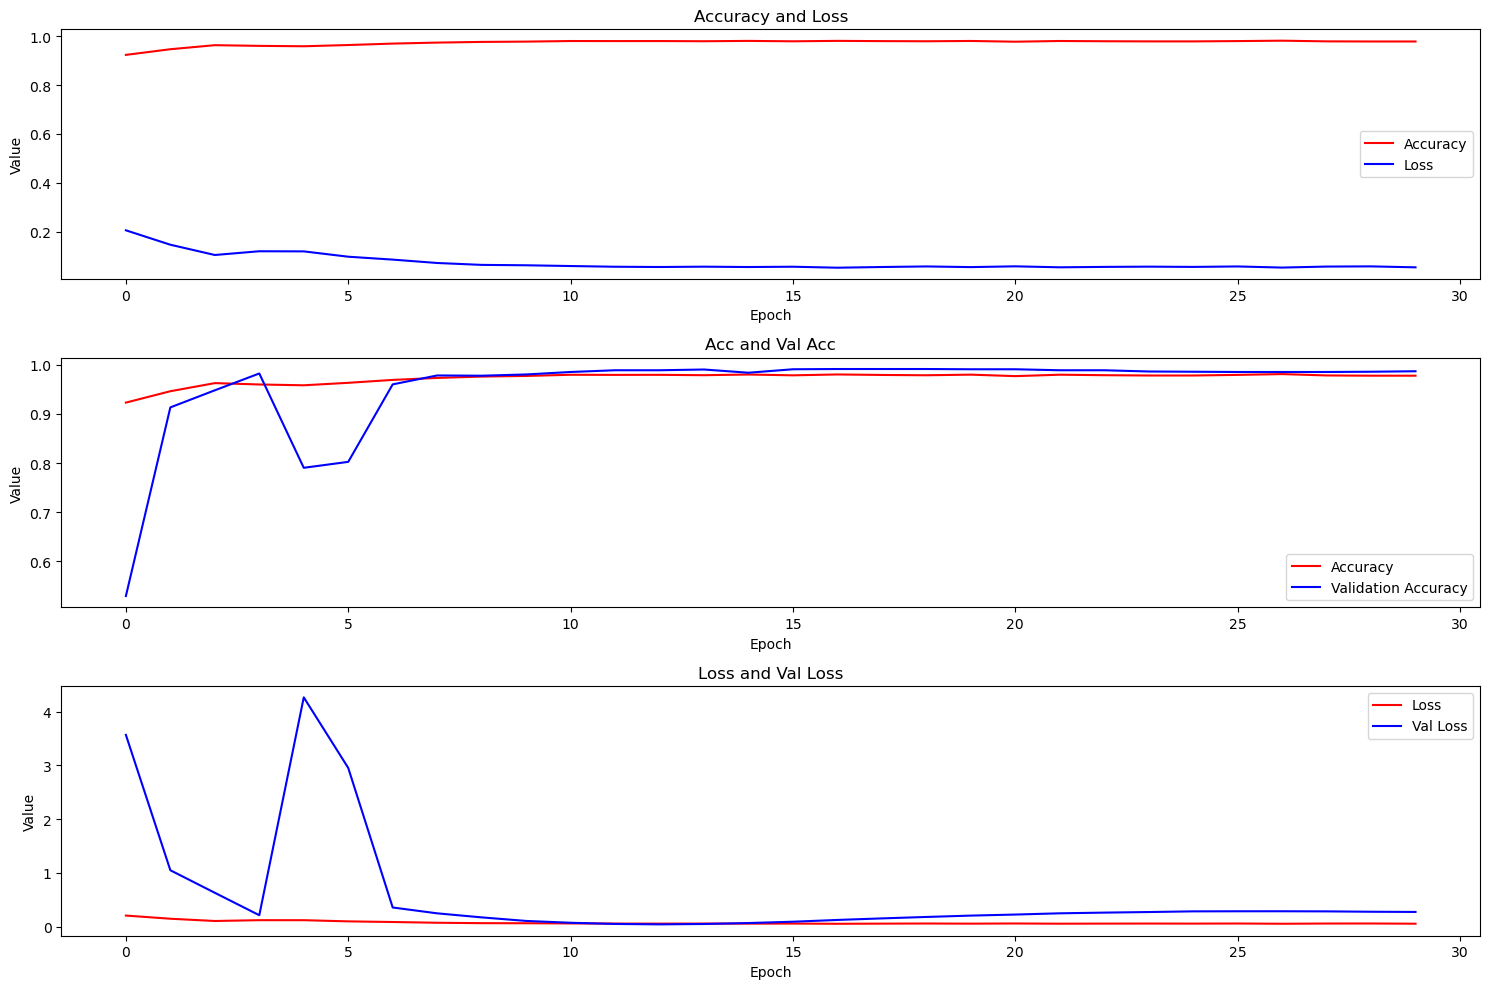

In [31]:
import matplotlib.pyplot as plt

accuracy = hist.history['accuracy']
validation_accuracy = hist.history['val_accuracy']
loss = hist.history['loss']
validation_loss = hist.history['val_loss']

fig, ax = plt.subplots(nrows = 3, figsize = (15, 10))

ax[0].plot(accuracy, 'r', label='Accuracy')
ax[0].plot(loss, 'b', label='Loss')
ax[0].set_title('Accuracy and Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Value')
ax[0].legend(loc = 0)

ax[1].plot(accuracy, 'r', label='Accuracy')
ax[1].plot(validation_accuracy, 'b', label='Validation Accuracy')
ax[1].set_title('Acc and Val Acc')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Value')
ax[1].legend(loc = 0)

ax[2].plot(loss, 'r', label='Loss')
ax[2].plot(validation_loss, 'b', label='Val Loss')
ax[2].set_title('Loss and Val Loss')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Value')
ax[2].legend(loc = 0)

plt.tight_layout()
plt.show()

In [22]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import os
import random

# Load the model
model = load_model('C:/Users/vian8/Desktop/Tugas2/SNAPGRADE/model/model_checkpoint.h5')

def predict(img_path):

    img = image.load_img(img_path, target_size=(32, 32))  
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) 
    img_array /= 255.0  
    
    pred  = model.predict(img_array)
    print(pred)
    return pred

1/1 [==============================] - 0s 127ms/step
[[2.6324242e-06 9.9999738e-01]]
1/1 [==============================] - 0s 126ms/step
[[0.9752099  0.02479009]]


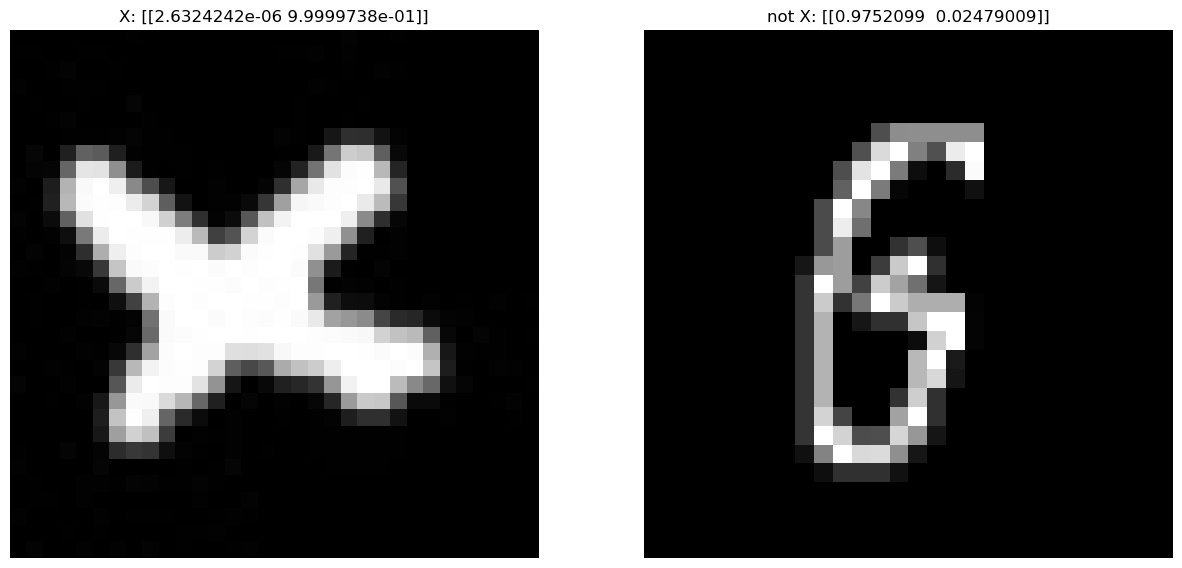

In [26]:
import matplotlib.pyplot as plt
from PIL import Image

x_files = os.listdir(x_dir)
test_x = os.path.join(x_dir, random.choice(x_files))  

not_x_files = os.listdir(not_x_dir)
test_not_x = os.path.join(not_x_dir, random.choice(not_x_files))

# Load images using PIL
img_x = Image.open(test_x).convert('L')
img_not_x = Image.open(test_not_x).convert('L')

# Display images and predictions
plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
plt.imshow(img_x, cmap='gray')
plt.title(f'X: {predict(test_x)}')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_not_x, cmap='gray')
plt.title(f'not X: {predict(test_not_x)}')
plt.axis('off')

plt.show()

In [33]:
from sklearn.metrics import classification_report, confusion_matrix

# Perform predictions on the validation generator
y_true = []  # Ground truth labels
y_pred = []  # Predicted labels

# Iterate through the validation generator to collect all ground truth labels and predictions
for x_batch, y_batch in val_gen:
    # Predict probabilities for each batch
    pred_probs = model.predict(x_batch)
    # Convert probabilities to binary predictions (0 or 1) with a threshold of 0.5
    pred_labels = (pred_probs > 0.5).astype(int)

    # Append true and predicted labels
    y_true.extend(y_batch)
    y_pred.extend(pred_labels)

    # Break the loop if we've gone through all data
    if len(y_true) >= val_gen.samples:
        break

# Convert lists to numpy arrays for metrics calculation
y_true = np.array(y_true).flatten()
# y_choice = np.argmax(y_pred)
y_prediction = np.array(y_pred).flatten()  # Flatten to ensure shapes match

# Generate classification report
print("Classification Report:")
print(classification_report(y_true, y_prediction, target_names=["Not X", "X"]))

# Generate confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_prediction))


1/1 [==============================] - 0s 74ms/step
Classification Report:
              precision    recall  f1-score   support

       Not X       0.99      0.99      0.99      2000
           X       0.99      0.99      0.99      2000

    accuracy                           0.99      4000
   macro avg       0.99      0.99      0.99      4000
weighted avg       0.99      0.99      0.99      4000

Confusion Matrix:
[[1983   17]
 [  17 1983]]


In [34]:
# import matplotlib.pyplot as plt

# Find indices of false positives and false negatives
false_positives = []
false_negatives = []

# Loop over the predictions and true labels
for i, (true, pred) in enumerate(zip(y_true, y_pred)):
    if pred == 1 and true == 0:  # False Positive
        false_positives.append(i)
    elif pred == 0 and true == 1:  # False Negative
        false_negatives.append(i)

# Display up to 5 samples of false positives and false negatives
num_samples = 5

# Function to display samples
def display_samples(indices, label):
    for i, idx in enumerate(indices[:num_samples]):
        plt.figure(figsize=(2, 2))
        plt.title(f"{label} Sample {i + 1}")
        plt.imshow(val_gen[idx][0].squeeze(), cmap='gray')
        plt.axis('off')
        plt.show()

print("False Positives:")
display_samples(false_positives, "False Positive")

print("False Negatives:")
display_samples(false_negatives, "False Negative")


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()